In [35]:
import pickle
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [36]:
#Setup Distrbuited training
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())   #Enables

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold #for K-fold cross validation
import numpy

Resolution = 100
X = X/255.0

numpy.random.seed(7)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []

for train, test in kfold.split(X, y):

    with strategy.scope():      #Enables multi-gpu
        model = Sequential([
            
            Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu', input_shape=(Resolution, Resolution, 1)),
            MaxPooling2D(pool_size=(1, 5), strides=(4)),
            
            Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
            MaxPooling2D(pool_size=(1, 4), strides=(3)),

            Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
            MaxPooling2D(pool_size=(1, 2), strides=(2)),

            Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2)),

            
            Flatten(),
            Dense(32, activation='relu',kernel_regularizer=regularizers.l2()),
            Dense(6, activation='softmax')
        ])


    #model.summary()

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizers.Adam(),                  #gradient descent
                metrics=['accuracy'])
                

    history = model.fit(X[train], y[train], batch_size=20, epochs=100, validation_split=0.2)
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))    

 val_accuracy: 0.9323
Epoch 63/100
39/39 [==============================] - 1s 14ms/step - loss: 0.2166 - accuracy: 0.9435 - val_loss: 0.1636 - val_accuracy: 0.9531
Epoch 64/100
39/39 [==============================] - 1s 15ms/step - loss: 0.1551 - accuracy: 0.9524 - val_loss: 0.1911 - val_accuracy: 0.9271
Epoch 65/100
39/39 [==============================] - 1s 15ms/step - loss: 0.1607 - accuracy: 0.9509 - val_loss: 0.1978 - val_accuracy: 0.9323
Epoch 66/100
39/39 [==============================] - 1s 15ms/step - loss: 0.1945 - accuracy: 0.9306 - val_loss: 0.3319 - val_accuracy: 0.8802
Epoch 67/100
39/39 [==============================] - 1s 15ms/step - loss: 0.2363 - accuracy: 0.9183 - val_loss: 0.1742 - val_accuracy: 0.9531
Epoch 68/100
39/39 [==============================] - 1s 14ms/step - loss: 0.1463 - accuracy: 0.9584 - val_loss: 0.2102 - val_accuracy: 0.9219
Epoch 69/100
39/39 [==============================] - 1s 15ms/step - loss: 0.1959 - accuracy: 0.9445 - val_loss: 0.1853 

38/38 - 0s - loss: 0.2216 - accuracy: 0.9292


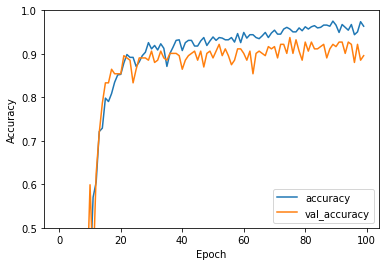

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X,  y, verbose=2)